In [31]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

from pyspark.ml import *
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.param import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import rand 
from sklearn.metrics import classification_report
from time import time
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import NGram
import pandas as pd
spark = SparkSession.builder.getOrCreate()

In [4]:
sc = spark.sparkContext
sc.setCheckpointDir('checkpoint')

df=spark.read.option("delimiter", "\t").csv("amazon_reviews_us_Wireless_v1_00.tsv",header=True)
df.show()
df.count()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...| 2015-08-31|
|         US|   50800750|R15V54KBMTQWAY|B00XK95RPQ|     516894650|Selfie Stick Fibl...|        Wireless|          4|    

263652

ADDING THE LABELS

Here we are adding the labels to the code that we will be using to run the sentimental analysis. we will label the reviews of 3 stars with an indicator of 0, reviews with less than 3 stars will be labeled with an indicator of -1 and reviews with greater than 3 stars will be labeled with an indicator of 1. So we add the column with the indicators.

In [5]:
df = df.filter((df.star_rating != 3))
df=df.withColumn('label', f.when(f.col('star_rating')<3,0).when(f.col('star_rating')>3,1))


In [6]:
df.registerTempTable("df")
# convert String labels to Double type
df = df.withColumn("label", df.label.cast(DoubleType()))
df.show()
df.count()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-----+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|label|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-----+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...| 2015-08-31|  0.0|
|         US|   50800750|R15V54KBMTQWAY|B00XK95RPQ|     516894650|Selfie Stick Fibl...|        W

243024

In [7]:

df=df.select('review_body','label')

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()



+-----------+-----+
|review_body|label|
+-----------+-----+
|         70|    0|
+-----------+-----+



In [8]:
df=df.where(col("review_body").isNotNull()).where(col("label").isNotNull())
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()
df=df.sample(withReplacement=False, fraction=0.0025)
df.count()

+-----------+-----+
|review_body|label|
+-----------+-----+
|          0|    0|
+-----------+-----+



675

In [9]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df)
# tokenizer 
tokenizer = RegexTokenizer(inputCol="review_body", outputCol="words", pattern="\W")##'\w' remove none-word letters
df_tokenized = tokenizer.transform(df)
# remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_removed = remover.transform(df_tokenized)

ngram = NGram(n=2, inputCol="filtered", outputCol="bigrams")
df_ngram = ngram.transform(df_removed)
# Convert to TF words vector
hashingTF = HashingTF(inputCol="bigrams", outputCol="rawFeatures")
df_TF = hashingTF.transform(df_ngram)
# Convert to TF*IDF words vector
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df_TF)
df_idf = idfModel.transform(df_TF)
for features_label in df_idf.select("features", "label").take(3):
    print(features_label)


Row(features=SparseVector(262144, {7252: 5.823, 22764: 5.823, 34324: 5.1299, 49723: 5.823, 55625: 5.823, 65428: 5.823, 101010: 5.823, 105861: 5.823, 150887: 5.1299, 157683: 5.823, 161109: 5.823, 193099: 5.823, 193703: 5.4176, 255760: 5.4176}), label=0.0)
Row(features=SparseVector(262144, {61026: 4.1183, 87846: 5.823, 156904: 5.823, 164111: 3.9512, 208597: 5.823, 245921: 5.823, 255410: 5.823}), label=1.0)
Row(features=SparseVector(262144, {762: 5.1299, 5500: 5.4176, 12354: 5.823, 14237: 5.823, 18773: 5.823, 22070: 5.1299, 26085: 5.823, 28676: 5.823, 29421: 5.823, 33005: 5.823, 44305: 5.823, 46190: 5.4176, 48831: 5.823, 50357: 5.823, 51112: 5.4176, 54515: 5.823, 60523: 5.823, 61592: 5.823, 63854: 5.823, 65303: 5.823, 69821: 5.823, 73410: 5.4176, 74905: 5.4176, 84749: 5.823, 85460: 5.823, 86346: 5.823, 86658: 5.823, 89643: 5.823, 92784: 5.823, 102206: 5.823, 108025: 5.823, 111210: 5.823, 117931: 5.823, 124665: 5.823, 127711: 5.823, 127842: 5.1299, 128427: 23.2922, 135778: 5.823, 136364: 5

# Splitting the data

In [10]:
# Split data aproximately into training (80%) and test (20%)
(train, test)=df.randomSplit([0.8,0.2], seed = 0)
# Cache the train and test data in-memory 
train = train.cache()
test = test.cache()
print ('Sample number in the train set : {}'.format(train.count()))
print ('Sample number in the test set : {}'.format(test.count()))
train.groupby('label').count().toPandas()

Sample number in the train set : 535
Sample number in the test set : 140


,label,count
0,0.0,130
1,1.0,405


## Data Modeling

## Logistic Regression

In [18]:
def grid_search(p1,p2,p3,p4):
    lr = LogisticRegression()
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, ngram, hashingTF, idfModel, lr])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(lr.regParam, [p2])
                 .addGrid(lr.elasticNetParam, [p3])
                 .addGrid(lr.maxIter, [p4])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print ('average cross-validation accuracy = {}'.format(average_score[0]))
    return average_score[0]

In [19]:
score=0.0
for p1 in [45000,50000,55000]:
    for p2 in [0.09,0.10,0.11]:
        for p3 in [0.09,0.10,0.11]:
            for p4 in [9,10,11]:
                t0 = time()
                print ('(numFeatures,regParam,elasticNetParam,maxIter)=({},{},{},{})'.format(p1,p2,p3,p4))
                average_score=grid_search(p1,p2,p3,p4)
                tt = time() - t0
                print ("Classifier trained in {} seconds".format(round(tt,3)))
                if average_score > score:
                    print ('################ Best score ######################')
                    params=(p1,p2,p3,p4)
                    score=average_score
print ('Best score is {} at params ={}'.format(score, params))

(numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.09,9)
average cross-validation accuracy = 0.21929568390633142
Classifier trained in 26.138 seconds
################ Best score ######################
(numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.09,10)
average cross-validation accuracy = 0.21529568390633141
Classifier trained in 19.306 seconds
(numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.09,11)
average cross-validation accuracy = 0.21929568390633142
Classifier trained in 18.559 seconds
(numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.1,9)
average cross-validation accuracy = 0.21929568390633142
Classifier trained in 15.39 seconds
(numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.1,10)
average cross-validation accuracy = 0.21529568390633141
Classifier trained in 17.961 seconds
(numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.1,11)
average cross-validation accuracy = 0.21529568390633141
Classifier trained in 17.4

In [14]:
def Data_modeling(train, test, pipeline, paramGrid):
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    
    ########  Make predictions on on the test data
    prediction = cvModel.transform(test)
    average_score = cvModel.avgMetrics
    print ('average cross-validation accuracy = {}'.format(average_score[0]))
    ######## Calculate accuracy of the prediction of the test data
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    accuracy_score=evaluator.evaluate(prediction)
    # another way to calculate accuracy 
    #correct=prediction.filter(prediction['label']== prediction['prediction']).select("label","prediction")
    #accuracy_score = correct.count() / float(test.count())  
    print ('Accuracy in the test data = {}'.format(accuracy_score))
    
    ######## calculate F1 score of the prediction of the test data
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score=evaluator.evaluate(prediction)
    print ('F1 score in the test data = {}'.format(f1_score))
    # Calculate area under ROC for the prediction of the test data
    #evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
    #ROC_score=evaluator.evaluate(prediction)
    #print 'areaUnderROC in the test data = {}'.format(ROC_score)
    
    ######## Print classification_report
    prediction_and_labels=prediction.select("label","prediction")
    y_true = []
    y_pred = []
    for x in prediction_and_labels.collect():
        xx = list(x)
        try:
            tt = int(xx[1])
            pp = int(xx[0])
            y_true.append(tt)
            y_pred.append(pp)
        except:
            continue

    target_names = ['neg 0', 'pos 1']
    print (classification_report(y_true, y_pred, target_names=target_names))
    return 


In [22]:
# trained by a logistic regression 
lr = LogisticRegression()
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover,ngram, hashingTF, idfModel, lr])

# Create ParamGrid for Cross Validation 
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [50000])
             .addGrid(lr.regParam, [0.10])
             .addGrid(lr.elasticNetParam, [0.10])
             .addGrid(lr.maxIter, [10])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)

average cross-validation accuracy = 0.21549542816906786
Accuracy in the test data = 0.2727272727272727
F1 score in the test data = 0.6124401913875599
              precision    recall  f1-score   support

       neg 0       0.00      0.00      0.00         0
       pos 1       1.00      0.73      0.84       132

    accuracy                           0.73       132
   macro avg       0.50      0.36      0.42       132
weighted avg       1.00      0.73      0.84       132



## Naive Bayes


In [16]:
def grid_search(p1,p2):
    nb = NaiveBayes()
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover,ngram, hashingTF, idfModel, nb])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(nb.smoothing, [p2])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print ('average cross-validation accuracy = {}'.format(average_score[0]))
    return average_score[0]

In [17]:
score=0.0
for p1 in [35000,40000,55000]:
    for p2 in [0.8,0.9,1.0]:
      t0 = time()
      print ('(numFeatures,smoothing)=({},{})'.format(p1,p2))
      average_score=grid_search(p1,p2)
      tt = time() - t0
      print ("Classifier trained in {} seconds".format(round(tt,3)))
      if average_score > score:
        print ('################ Best score ######################')
        params=(p1,p2)
        score=average_score
print ('Best score is {} at params ={}'.format(score, params))


(numFeatures,smoothing)=(35000,0.8)
average cross-validation accuracy = 0.4037320087728993
Classifier trained in 23.386 seconds
################ Best score ######################
(numFeatures,smoothing)=(35000,0.9)
average cross-validation accuracy = 0.39797298541833454
Classifier trained in 18.32 seconds
(numFeatures,smoothing)=(35000,1.0)
average cross-validation accuracy = 0.39849897606937196
Classifier trained in 16.687 seconds
(numFeatures,smoothing)=(40000,0.8)
average cross-validation accuracy = 0.3716011898504533
Classifier trained in 16.918 seconds
(numFeatures,smoothing)=(40000,0.9)
average cross-validation accuracy = 0.37008740088162834
Classifier trained in 16.656 seconds
(numFeatures,smoothing)=(40000,1.0)
average cross-validation accuracy = 0.3718859620327075
Classifier trained in 16.42 seconds
(numFeatures,smoothing)=(55000,0.8)
average cross-validation accuracy = 0.3645723187547484
Classifier trained in 16.366 seconds
(numFeatures,smoothing)=(55000,0.9)
average cross-va

In [18]:
# trained by a Naïve Bayes 
nb = NaiveBayes()
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover,ngram, hashingTF, idfModel, nb])
# Create ParamGrid for Cross Validation 
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [40000])
             .addGrid(nb.smoothing, [1.0])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)


average cross-validation accuracy = 0.3718859620327075
Accuracy in the test data = 0.40714285714285714
F1 score in the test data = 0.6401710244214988
              precision    recall  f1-score   support

       neg 0       0.72      0.26      0.39        68
       pos 1       0.57      0.90      0.70        72

    accuracy                           0.59       140
   macro avg       0.64      0.58      0.54       140
weighted avg       0.64      0.59      0.55       140



# Decision Tree

In [23]:
def grid_search(p1,p2,p3):
    # trained by a Decision Tree 
    dt = DecisionTreeClassifier(labelCol="indexedLabel",impurity="entropy")
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover,ngram, hashingTF, idfModel, dt])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(dt.maxDepth, [p2])
                 .addGrid(dt.minInstancesPerNode, [p3])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print ('average cross-validation accuracy = {}'.format(average_score[0]))
    return average_score[0]

In [24]:
score=0.0
for p1 in [65000,70000,75000]:
    for p2 in [23,24,25,26,27]:
        for p3 in [3,4,5]:
          t0 = time()
          print ('(numFeatures,maxDepth,minInstancesPerNode)=({},{},{})'.format(p1,p2,p3))
          average_score=grid_search(p1,p2,p3)
          tt = time() - t0
          print ("Classifier trained in {} seconds".format(round(tt,3)))
          if average_score > score:
            print ('################ Best score ######################')
            params=(p1,p2,p3)
            score=average_score
print ('Best score is {} at params ={}'.format(score, params))

(numFeatures,maxDepth,minInstancesPerNode)=(65000,23,3)
average cross-validation accuracy = 0.7722010343339095
Classifier trained in 44.926 seconds
################ Best score ######################
(numFeatures,maxDepth,minInstancesPerNode)=(65000,23,4)
average cross-validation accuracy = 0.7542528298722688
Classifier trained in 42.377 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(65000,23,5)
average cross-validation accuracy = 0.7479503088638655
Classifier trained in 38.898 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(65000,24,3)
average cross-validation accuracy = 0.7722010343339095
Classifier trained in 44.886 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(65000,24,4)
average cross-validation accuracy = 0.7542528298722688
Classifier trained in 43.15 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(65000,24,5)
average cross-validation accuracy = 0.7479503088638655
Classifier trained in 39.267 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(65000,25,3)
averag

In [26]:
# trained by a Decision Tree 
dt = DecisionTreeClassifier(labelCol="indexedLabel",impurity="entropy")
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover,ngram, hashingTF, idfModel, dt])
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [70000])
             .addGrid(dt.maxDepth, [25])
             .addGrid(dt.minInstancesPerNode, [4])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)

average cross-validation accuracy = 0.7623974657452222
Accuracy in the test data = 0.8071428571428572
F1 score in the test data = 0.11682830659061824
              precision    recall  f1-score   support

       neg 0       0.88      0.17      0.28       132
       pos 1       0.04      0.62      0.08         8

    accuracy                           0.19       140
   macro avg       0.46      0.40      0.18       140
weighted avg       0.83      0.19      0.27       140



## Random Forest 

In [32]:
def grid_search(p1,p2,p3,p4):
    rf = RandomForestClassifier(labelCol="indexedLabel",impurity="entropy", seed=5043)
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover,ngram, hashingTF, idfModel, rf])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(rf.numTrees, [p2])
                 .addGrid(rf.maxDepth, [p3])
                 .addGrid(rf.minInstancesPerNode, [p4])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print ('average cross-validation accuracy = {}'.format(average_score[0]))
    return average_score[0]

In [33]:
score=0.0
for p1 in [45000,50000,55000]:
    for p2 in [30,31,32]:
        for p3 in [28,29,30]:
            for p4 in [1,2]:
                t0 = time()
                print ('(numFeatures,numTrees,maxDepth,minInstancesPerNode)=({},{},{},{})'.format(p1,p2,p3,p4))
                average_score=grid_search(p1,p2,p3,p4)
                tt = time() - t0
                print ("Classifier trained in {} seconds".format(round(tt,3)))
                if average_score > score:
                  print ('################ Best score ######################')
                  params=(p1,p2,p3,p4)
                  score=average_score
print ('Best score is {} at params ={}'.format(score, params))

(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,30,28,1)
average cross-validation accuracy = 0.7551304984487495
Classifier trained in 45.525 seconds
################ Best score ######################
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,30,28,2)
average cross-validation accuracy = 0.7551304984487495
Classifier trained in 45.85 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,30,29,1)
average cross-validation accuracy = 0.7551304984487495
Classifier trained in 47.664 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,30,29,2)
average cross-validation accuracy = 0.7551304984487495
Classifier trained in 46.654 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,30,30,1)
average cross-validation accuracy = 0.7551304984487495
Classifier trained in 48.046 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,30,30,2)
average cross-validation accuracy = 0.7551304984487495
Classifier trained in 47.52

In [34]:
rf = RandomForestClassifier(labelCol="indexedLabel",impurity="entropy", seed=5043)
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover,ngram, hashingTF, idfModel, rf])

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [50000])
             .addGrid(rf.numTrees, [31])
             .addGrid(rf.maxDepth, [29])
             .addGrid(rf.minInstancesPerNode, [1])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)

average cross-validation accuracy = 0.7551304984487495
Accuracy in the test data = 0.8214285714285714
F1 score in the test data = 0.05411255411255411
              precision    recall  f1-score   support

       neg 0       1.00      0.18      0.30       140
       pos 1       0.00      0.00      0.00         0

    accuracy                           0.18       140
   macro avg       0.50      0.09      0.15       140
weighted avg       1.00      0.18      0.30       140



## Gradient Boosted Tree 

In [11]:
def grid_search(p1,p2,p3,p4):
    gbt = GBTClassifier(labelCol="indexedLabel")
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover,ngram, hashingTF, idfModel, gbt])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(gbt.maxIter, [p2]) #(default: 20)
                 .addGrid(gbt.maxDepth, [p3])
                 .addGrid(gbt.minInstancesPerNode, [p4])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print ('average cross-validation accuracy = {}'.format(average_score[0]))
    return average_score[0]

In [12]:
score=0.0
for p1 in [60000]:
    for p2 in [25,26,27]:
        for p3 in [18,19,20]:
            for p4 in [2]:
                t0 = time()
                print ('(numFeatures,maxIter,maxDepth,minInstancesPerNode)=({},{},{},{})'.format(p1,p2,p3,p4))
                average_score=grid_search(p1,p2,p3,p4)
                tt = time() - t0
                print ("Classifier trained in {} seconds".format(round(tt,3)))
                if average_score > score:
                  print ('################ Best score ######################')
                  params=(p1,p2,p3,p4)
                  score=average_score
print ('Best score is {} at params ={}'.format(score, params))

(numFeatures,maxIter,maxDepth,minInstancesPerNode)=(60000,25,18,2)
average cross-validation accuracy = 0.7838735218002336
Classifier trained in 590.072 seconds
################ Best score ######################
(numFeatures,maxIter,maxDepth,minInstancesPerNode)=(60000,25,19,2)
average cross-validation accuracy = 0.7870407281732287
Classifier trained in 549.232 seconds
################ Best score ######################
(numFeatures,maxIter,maxDepth,minInstancesPerNode)=(60000,25,20,2)
average cross-validation accuracy = 0.7833650381519973
Classifier trained in 567.206 seconds
(numFeatures,maxIter,maxDepth,minInstancesPerNode)=(60000,26,18,2)
average cross-validation accuracy = 0.7843644984456689
Classifier trained in 518.043 seconds
(numFeatures,maxIter,maxDepth,minInstancesPerNode)=(60000,26,19,2)
average cross-validation accuracy = 0.7870407281732287
Classifier trained in 541.88 seconds
(numFeatures,maxIter,maxDepth,minInstancesPerNode)=(60000,26,20,2)
average cross-validation accurac

In [15]:
# trained by a Gradient Boosted Tree 
gbt = GBTClassifier(labelCol="indexedLabel")
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover,ngram, hashingTF, idfModel, gbt])
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [60000])
             .addGrid(gbt.maxIter, [25]) #(default: 20)
             .addGrid(gbt.maxDepth, [19])
             .addGrid(gbt.minInstancesPerNode, [2])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)


average cross-validation accuracy = 0.7870407281732287
Accuracy in the test data = 0.8285714285714286
F1 score in the test data = 0.09878293749261491
              precision    recall  f1-score   support

       neg 0       0.80      0.15      0.26       131
       pos 1       0.03      0.44      0.06         9

    accuracy                           0.17       140
   macro avg       0.42      0.30      0.16       140
weighted avg       0.75      0.17      0.24       140



## Evaluation of performance 

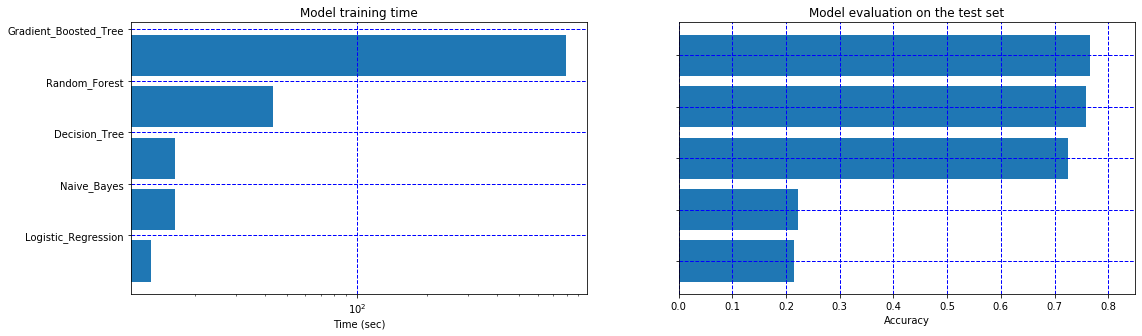

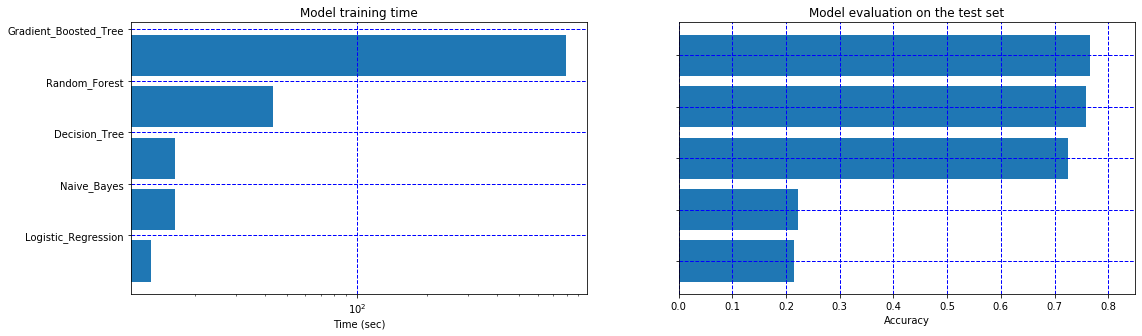

In [6]:
import matplotlib.pyplot as plt
classifier_names=['Logistic_Regression', 'Naive_Bayes', 'Decision_Tree', 'Random_Forest', 'Gradient_Boosted_Tree']
time=[13.031,16.534,16.534,43.519,799.533]
accuracy=[0.214876,0.2231404958677686,0.7258064516129032,0.7580645,0.766129]
fscore=[]
recall=[]
precision=[]

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5), facecolor='white')
ax[0].barh(np.arange(0, 5),time)
ax[0].set_yticks(np.arange(0.5, 5.5))
ax[0].set_yticklabels(classifier_names)
ax[0].grid(color='b', linestyle='--', linewidth=1)
ax[0].set_title('Model training time')
ax[0].set_xlabel('Time (sec)')
ax[0].set_xscale('log')

ax[1].barh(range(0, len(classifier_names)),accuracy)
ax[1].set_xlim([0,0.85])
ax[1].set_title('Model evaluation on the test set')
ax[1].set_xlabel('Accuracy')
ax[1].set_yticklabels([])
ax[1].grid(color='b', linestyle='--', linewidth=1)

ax[0].barh(np.arange(0, 5),time)
ax[0].set_yticks(np.arange(0.5, 5.5))
ax[0].set_yticklabels(classifier_names)
ax[0].grid(color='b', linestyle='--', linewidth=1)
ax[0].set_title('Model training time')
ax[0].set_xlabel('Time (sec)')
ax[0].set_xscale('log')
display(fig)
